In [1]:
import bempp.api 
import numpy as np
import mtf

from mtf.config import config
from bempp.api.operators.boundary.sparse import identity
from mtf.operators.maxwell import assemble_mtf
from mtf.utils.iterative import gmres
from mtf.functions import define_bempp_functions

from matplotlib import pyplot as plt
bempp.api.enable_console_logging()
import argparse

parser = argparse.ArgumentParser(description="Set parameters")

parser.add_argument("--M", default=3, type=int)
parser.add_argument("--solver", default='gmres', type=str)
parser.add_argument("--precision", default=10, type=int)
parser.add_argument("--case", default="B", type=str)
args = parser.parse_args([])

M = args.M
solver = args.solver
case = args.case
precision = args.precision

M = 2
case = 'A'
shape = 'cube'
precision = 20

print('Solver is: ', solver)
config = mtf.config.set_case(case, False)
k0 = config['k_ext']
k1 = config['k_int']

if M == 2:
    #multiple shape, M=2
    segments = [[10, 20], [10, 20]]
    swapped_normals = [[10, 20], []]
elif M == 3:
    #multiple shape, M=3
    segments = [[10, 20], [10, 12], [12, 20]]
    swapped_normals = [[10, 20], [], [12]]

## Same for the multishape
if shape == 'cube':
    segments = [[1, 2, 3, 4, 5, 7, 8, 9, 10, 11],
                [1, 2, 3, 4, 5, 6],
                [6, 7, 8, 9, 10, 11]]
    
    swapped_normals = [[1, 2, 3, 4, 5, 7, 8, 9, 10, 11],[],[6]]

# Outside: k_ext
# Inside: k_int
# Cjecl general 

k_list = [k0]
eta_rel_list = [1]
mu_list = [config['mu_ext']]

for index in range(M-1):
  k_list.append(k1)
  mu_list.append(config['mu_int'])
  eta_rel_list.append(config['eta_rel'])

print("k_ext: {:.2f}".format(config['k_ext']))
print("k_int: {:.2f}".format(config['k_int']))

print("----")
print("lambda: {:.2f}".format(config['lambda']))
print("f: {:.2E}".format(config['frequency']))

h = 2 * np.pi/(precision*k0)
if shape == 'sphere':
    grid = bempp.api.shapes.multitrace_sphere(h=h)
elif shape == 'cube':
    grid = bempp.api.shapes.multitrace_cube(h=h)
else:
    print('choose a valid shape')

bempp.api.export(shape + str(precision) + '.msh', grid)

Solver is:  gmres
k_ext: 3.00
k_int: 4.35
----
lambda: 2.09
f: 1.43E+08



bempp:HOST:INFO: Created grid with id 25e0c607-b6f8-48d4-b9ba-9c93c8bbc120. Elements: 1758. Edges: 2617. Vertices: 862


In [ ]:
params = {}
params["M"] = M
params["k_list"] = k_list
params["mu_list"] = mu_list
params["eta_rel_list"] = eta_rel_list
params["segments"] = segments
params["swapped_normals"] = swapped_normals


if solver == 'gmres':
    lhs_prec, lhs_op, rhs = assemble_mtf(grid, params, config, solver=solver)
    P_wf = lhs_prec.weak_form()
else:
    lhs_op, rhs = assemble_mtf(grid, params, config, solver=solver)

# Solver

op_wf = lhs_op.weak_form()
op_sf = lhs_op.strong_form()

b_wf = bempp.api.assembly.blocked_operator.projections_from_grid_functions_list(
    rhs, lhs_op.dual_to_range_spaces
)


N = b_wf.shape[0]
print(N)
x_gmres, conv_gmres, res_gmres = gmres(P_wf * op_wf, P_wf * b_wf, return_residuals=True, restart = 2000, maxiter=1500)
x_unprec, conv_unprec, res_unprec = gmres(op_wf, b_wf, return_residuals=True, restart = 2000, maxiter=2000)

sol = bempp.api.assembly.blocked_operator.grid_function_list_from_coefficients(
    x_gmres.ravel(), lhs_op.domain_spaces
)


far_field_points = config['far_field_points']
electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[1].space, far_field_points, k0)
magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[0].space, far_field_points, k0)    

far_field =  electric_far * sol[1] + magnetic_far * sol[0]

A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k0) ))
rel_error = np.linalg.norm(uh - u) / np.linalg.norm(u)

if M == 3:
    interface = [12]
    interface_space = bempp.api.function_space(grid, "RWG", 0, segments=interface, include_boundary_dofs = True)

    map_dom0_to_interface = identity(sol[2].space, interface_space, interface_space)
    map_dom1_to_interface = identity(sol[4].space, interface_space, interface_space)
    
    trace0i = map_dom0_to_interface @ sol[2]
    trace1i = map_dom1_to_interface @ sol[4]
    
    normal_trace0i = map_dom0_to_interface @ sol[3]
    normal_trace1i = map_dom1_to_interface @ sol[5]
    
    dirichlet_jump = (trace0i + trace1i).l2_norm() / (trace0i.l2_norm())
    neumann_jump = (normal_trace0i + normal_trace1i).l2_norm() / (normal_trace0i.l2_norm())
    
    print(dirichlet_jump,': L^2 relative error for tangential traces')
    print(neumann_jump,': L^2 relative error for magnetic traces')

    interface_space_p1 = bempp.api.function_space(grid, "P", 1)

    c_p1 = np.linalg.norm(trace0i.evaluate_on_vertices(),axis=0)
    
    u_p1 = bempp.api.GridFunction(interface_space_p1, coefficients = c_p1)
elif M ==2: 
    dirichlet_jump = -1
    neumann_jump = -1
print(rel_error)


bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
/usr/local/lib/python3.10/dist-packages/bempp/api/assembly/discrete_boundary_operator.py:639: SparseEfficiencyWarning: splu converted its input to CSC format
  solver = solver_interface(actual_mat)
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)
/usr/local/lib/python3.10/dist-packages/bempp/api/assembly/discrete_boundary_operator.py:639: 

7548


bempp:HOST:INFO: GMRES Iteration 3 with residual 0.423890037744278
bempp:HOST:INFO: GMRES Iteration 4 with residual 0.35567952670693076
bempp:HOST:INFO: GMRES Iteration 5 with residual 0.30689668875712456
bempp:HOST:INFO: GMRES Iteration 6 with residual 0.2471308162340061
bempp:HOST:INFO: GMRES Iteration 7 with residual 0.22674116503819194
bempp:HOST:INFO: GMRES Iteration 8 with residual 0.20751631531278586
bempp:HOST:INFO: GMRES Iteration 9 with residual 0.188892755900873
bempp:HOST:INFO: GMRES Iteration 10 with residual 0.17317953027593494
bempp:HOST:INFO: GMRES Iteration 11 with residual 0.15682581336920381
bempp:HOST:INFO: GMRES Iteration 12 with residual 0.1425081209386419
bempp:HOST:INFO: GMRES Iteration 13 with residual 0.13080763807997897
bempp:HOST:INFO: GMRES Iteration 14 with residual 0.11783360093344214
bempp:HOST:INFO: GMRES Iteration 15 with residual 0.10957023516501865
bempp:HOST:INFO: GMRES Iteration 16 with residual 0.10369231938078102
bempp:HOST:INFO: GMRES Iteration 

In [ ]:
res0 = np.load("results/" + str(M) + case + str(10) + "mtf" + solver + 'gmres' + str(shape) +'.npy').ravel()
res1 = np.load("results/" + str(M) + case + str(20) + "mtf" + solver + 'gmres' + str(shape) + '.npy').ravel()

res0_unprec = np.load("results/" + str(M) + case + str(10) + "mtf" + solver + 'gmres_unprec' + str(shape) + '.npy').ravel()
res1_unprec = np.load("results/" + str(M) + case + str(20) + "mtf" + solver + 'gmres_unprec' + str(shape) + '.npy').ravel()

NameError: name 'far_field' is not defined

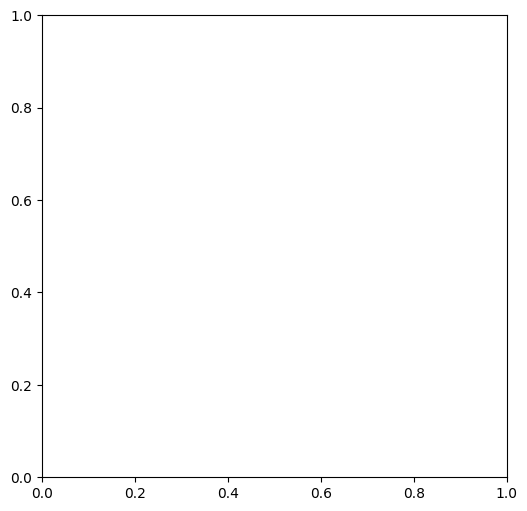

In [4]:
angles = config['angles']

fig, ax  = plt.subplots(1,1, figsize=(6,6))
plt.rcParams['figure.figsize'] = (15, 4) # Increase the figure size in the notebook

A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k0) ))
# -1j * kExt is to make agree with eqn 3.21 p70 tBohren and Huffman

ax.plot(angles[:1801], uh, '-r', label='BEM')
ax.plot(angles[:1801], u, 'b', label='MIE', linestyle=(0, (5, 5)))

ax.set_xlabel(r"$\theta$ (rad)", fontsize=15)
ax.set_ylabel(r"$\mathrm{RCS}_z(\theta)$", fontsize=15)

ymin, ymax = uh.min() - 1, uh.max() + 1
ax.legend(prop={'size': 14})
ax.grid()
plt.xlim(-0.1, np.pi + 0.1)
#plt.ylim(ymin, ymax)
plt.savefig('results/' + case + 's1-RCSSphere.pdf')
plt.show()